# 🏀 Prédiction NBA – Qui gagne entre deux équipes ?

Ce notebook a pour but de construire un modèle de machine learning capable de prédire si l’équipe A va gagner un match contre l’équipe B, à partir des statistiques moyennes de chaque équipe. On va :

- Enrichir les données avec des ratios, styles, clustering, t-SNE
- Construire un dataset équipe A vs équipe B
- Entraîner plusieurs modèles (Random Forest, XGBoost, etc.)
- Tester des prédictions manuelles

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

df = pd.read_parquet("../data/curated/team_gamelog_all_seasons.parquet")
df["WIN"] = df["WL"].map({"W": 1, "L": 0})
df.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,season,WIN
0,21999,1610612746,LAC,Los Angeles Clippers,0029900012,1999-11-02,LAC vs. SEA,L,240,35,...,14,4,9,18,24,92,-12,0,1999-00,0.0
1,21999,1610612761,TOR,Toronto Raptors,0029900006,1999-11-02,TOR vs. BOS,L,240,33,...,22,9,7,17,20,90,-13,0,1999-00,0.0
2,21999,1610612738,BOS,Boston Celtics,0029900006,1999-11-02,BOS @ TOR,W,240,38,...,21,12,4,18,30,103,13,0,1999-00,1.0
3,21999,1610612764,WAS,Washington Wizards,0029900003,1999-11-02,WAS vs. ATL,W,240,39,...,23,5,5,15,30,94,7,0,1999-00,1.0
4,21999,1610612763,VAN,Vancouver Grizzlies,0029900013,1999-11-02,VAN vs. POR,L,240,30,...,19,4,3,17,23,86,-20,0,1999-00,0.0


In [2]:
print(df.columns.tolist())

['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'season', 'WIN']


### Étape 2 – Calcul des statistiques moyennes

On calcule les moyennes globales par équipe sur toutes les saisons.  
On ajoute aussi des **ratio** qui aident à mieux distinguer les styles :
- `AST/TOV` : qualité de passe vs pertes de balle
- `OREB/REB` : agressivité offensive
- `FG3A/FGA` : dépendance au tir à 3 points

In [3]:
df["AST_TOV_ratio"] = df["AST"] / (df["TOV"] + 1e-5)
df["OREB_ratio"] = df["OREB"] / (df["REB"] + 1e-5)
df["Three_Point_Rate"] = df["FG3A"] / (df["FGA"] + 1e-5)

features = [
    'PTS', 'AST', 'REB', 'STL', 'BLK', 'TOV', 'OREB', 'DREB',
    'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
    'FTM', 'FTA', 'FT_PCT', 'PF',
    'AST_TOV_ratio', 'OREB_ratio', 'Three_Point_Rate'
]

team_stats = df.groupby("TEAM_NAME")[features].mean()
team_stats.head()

,PTS,AST,REB,STL,BLK,TOV,OREB,DREB,FGM,FGA,...,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,PF,AST_TOV_ratio,OREB_ratio,Three_Point_Rate
TEAM_NAME,,,,,,,,,,,,,,,,,,,,,
Atlanta Hawks,101.495769,22.540567,42.363365,7.625684,4.813340,14.845197,10.981085,31.382280,37.841215,83.288701,...,7.957193,22.332006,0.352329,17.856147,23.270781,0.766738,20.515182,1.663704,0.257019,0.264606
Boston Celtics,102.456802,22.882820,42.232870,8.091857,4.658391,14.521847,10.265641,31.967229,37.768123,82.651936,...,8.838133,24.500497,0.357021,18.082423,23.422046,0.773870,21.599305,1.727607,0.241273,0.292235
Brooklyn Nets,106.800830,23.375519,43.434647,7.076763,4.740664,14.532158,10.116183,33.318465,39.217842,85.519710,...,10.800830,30.116183,0.356046,17.564315,22.917012,0.767946,20.026971,1.752452,0.230480,0.350776
Charlotte Bobcats,94.599502,21.036070,40.478856,7.452736,5.101990,14.512438,11.003731,29.475124,35.361940,80.274876,...,5.379353,15.547264,0.343000,18.496269,25.123134,0.735056,21.028607,1.584495,0.269449,0.194331
Charlotte Hornets,103.878730,23.637151,43.672762,7.469682,5.057748,13.403272,10.512993,33.159769,38.150144,85.552454,...,9.435996,26.758422,0.348799,18.142445,23.763234,0.764395,19.011550,1.954771,0.239114,0.309422


### Étape 3 – Définir un style de jeu par équipe

À partir des scores offensifs et défensifs (pondérations simples), on normalise les scores et on attribue à chaque équipe un **style de jeu** :
- **offensif** si score offensif > moyenne + seuil
- **défensif** si score défensif > moyenne + seuil
- **équilibré** sinon

In [4]:
team_stats["off_score"] = team_stats["PTS"] + team_stats["AST"] + team_stats["FG3M"] + team_stats["OREB"]
team_stats["def_score"] = team_stats["REB"] + team_stats["STL"] + team_stats["BLK"] - team_stats["TOV"]

team_stats["off_score_norm"] = (team_stats["off_score"] - team_stats["off_score"].mean()) / team_stats["off_score"].std()
team_stats["def_score_norm"] = (team_stats["def_score"] - team_stats["def_score"].mean()) / team_stats["def_score"].std()

def get_style(row, seuil=0.5):
    if row["off_score_norm"] > seuil: return "offensif"
    if row["def_score_norm"] > seuil: return "défensif"
    return "équilibré"

team_stats["style"] = team_stats.apply(get_style, axis=1)
team_stats[["off_score_norm", "def_score_norm", "style"]]

,off_score_norm,def_score_norm,style
TEAM_NAME,,,
Atlanta Hawks,0.013124,-0.450513,équilibré
Boston Celtics,0.246561,-0.119433,équilibré
Brooklyn Nets,1.303454,0.050446,offensif
Charlotte Bobcats,-1.728129,-1.393711,équilibré
Charlotte Hornets,0.726770,1.414624,offensif
Chicago Bulls,-0.412599,0.167644,équilibré
Cleveland Cavaliers,-0.122293,-0.259096,équilibré
Dallas Mavericks,0.504514,0.529102,offensif
Denver Nuggets,0.901184,0.967153,offensif


### Étape 4 – Visualiser les styles avec K-Means & t-SNE

On applique un **clustering K-Means** pour regrouper les équipes selon leur style de jeu.

Puis, on utilise **t-SNE** pour projeter les profils d’équipes dans un plan 2D et visualiser les groupes, les atypiques, et la diversité stratégique.

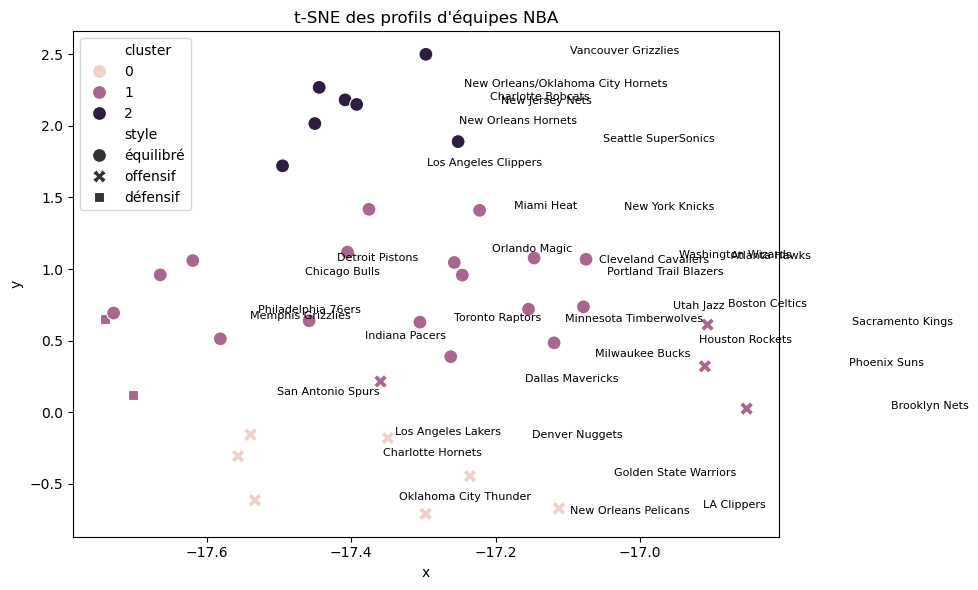

In [5]:
X = team_stats[["off_score_norm", "def_score_norm"]]
X_scaled = StandardScaler().fit_transform(X)

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
team_stats["cluster"] = kmeans.fit_predict(X_scaled)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)
team_stats["x"] = X_embedded[:, 0]
team_stats["y"] = X_embedded[:, 1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=team_stats, x="x", y="y", hue="cluster", style="style", s=100)
for i, name in enumerate(team_stats.index):
    plt.text(team_stats.iloc[i].x+0.2, team_stats.iloc[i].y, name, fontsize=8)
plt.title("t-SNE des profils d'équipes NBA")
plt.tight_layout()
plt.show()

### Étape 5 – Construire un jeu de données confrontation A vs B

Chaque ligne représente un match :
- `TEAM_NAME_A` à domicile
- `TEAM_NAME_B` à l'extérieur
- avec les stats moyennes de A et B fusionnées

On crée une variable cible `WIN_A` = 1 si A a gagné.

In [6]:
A = df[df.MATCHUP.str.contains("vs")].copy()
B = df[df.MATCHUP.str.contains("@")].copy()
A.columns = [f"{c}_A" if c != "GAME_ID" else c for c in A.columns]
B.columns = [f"{c}_B" if c != "GAME_ID" else c for c in B.columns]

matchups = pd.merge(A, B, on="GAME_ID")
matchups = matchups[matchups["TEAM_NAME_A"] != matchups["TEAM_NAME_B"]]
matchups["WIN_A"] = matchups["WL_A"].map({"W": 1, "L": 0})

In [7]:
matchups = matchups.merge(team_stats, left_on="TEAM_NAME_A", right_index=True, how="left")
matchups = matchups.rename(columns={col: f"{col}_Aavg" for col in team_stats.columns})

matchups = matchups.merge(team_stats, left_on="TEAM_NAME_B", right_index=True, how="left")
matchups = matchups.rename(columns={col: f"{col}_Bavg" for col in team_stats.columns})

### Étape 6 – Fusion des profils moyens de A et B

On ajoute les variables enrichies pour chaque équipe dans la ligne de match, en les renommant `xxx_Aavg` et `xxx_Bavg`.
Ce sont ces variables que le modèle utilisera.

In [8]:
X_cols = [c for c in matchups.columns if c.endswith("_Aavg") or c.endswith("_Bavg")]

In [9]:
# Sélection uniquement des colonnes numériques
X = matchups[X_cols].select_dtypes(include=[np.number])
y = matchups.loc[X.index, "WIN_A"]

# Nettoyage des NaN
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

### Étape 7 – Entraînement des modèles de prédiction

On entraîne plusieurs modèles classiques :
- Random Forest
- XGBoost
- KNN
- Régression logistique

On compare leurs performances avec :
- `accuracy` : précision globale
- `classification_report` : précision, rappel, f1-score

In [10]:
# Séparation du jeu de données
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Définir les modèles à tester
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

# Entraînement et évaluation
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} – Accuracy : {acc:.3f}")
    print(classification_report(y_test, y_pred))
    results[name] = model


Random Forest – Accuracy : 0.576
              precision    recall  f1-score   support

         0.0       0.47      0.28      0.35      2467
         1.0       0.61      0.78      0.68      3530

    accuracy                           0.58      5997
   macro avg       0.54      0.53      0.52      5997
weighted avg       0.55      0.58      0.55      5997



/Users/Othmane/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:19:20] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost – Accuracy : 0.581
              precision    recall  f1-score   support

         0.0       0.48      0.27      0.35      2467
         1.0       0.61      0.80      0.69      3530

    accuracy                           0.58      5997
   macro avg       0.55      0.53      0.52      5997
weighted avg       0.56      0.58      0.55      5997


KNN – Accuracy : 0.552
              precision    recall  f1-score   support

         0.0       0.45      0.38      0.41      2467
         1.0       0.61      0.67      0.64      3530

    accuracy                           0.55      5997
   macro avg       0.53      0.53      0.52      5997
weighted avg       0.54      0.55      0.54      5997


Logistic Regression – Accuracy : 0.599
              precision    recall  f1-score   support

         0.0       0.54      0.16      0.25      2467
         1.0       0.61      0.90      0.73      3530

    accuracy                           0.60      5997
   macro avg       0.57      0.53   

/Users/Othmane/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Étape 8 – Visualiser la matrice de confusion

Cela permet de voir combien de fois le modèle a correctement prédit :
- une victoire (1) comme victoire
- une défaite (0) comme défaite  
Et où il se trompe.

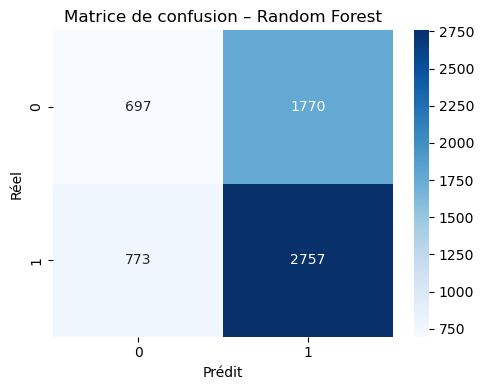

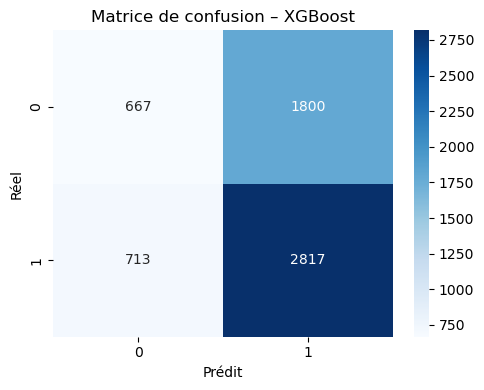

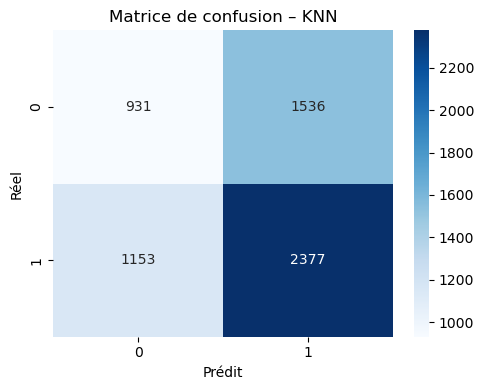

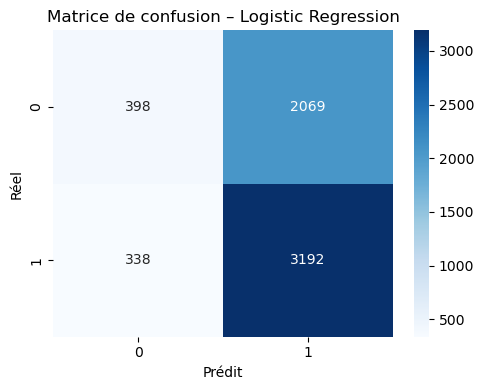

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for name, model in results.items():
    y_pred = model.predict(X_test)
    conf = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de confusion – {name}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.tight_layout()
    plt.show()

### Étape 9 – Tester une confrontation manuelle entre deux équipes

On choisit deux équipes, on récupère leurs profils moyens, et on laisse le modèle prédire qui gagne.

In [12]:
# Choix des équipes
equipe_A = "Orlando Magic"
equipe_B = "Milwaukee Bucks"

# Construire le vecteur manuel avec exactement les mêmes colonnes que X_train
X_manual = pd.DataFrame(columns=X_train.columns, index=[0])

# Remplir les valeurs pour l'équipe A
for col in [c for c in X_train.columns if c.endswith('_Aavg')]:
    base_col = col.replace('_Aavg', '')
    if base_col in team_stats.columns:
        X_manual.loc[0, col] = team_stats.loc[equipe_A, base_col]

# Remplir les valeurs pour l'équipe B
for col in [c for c in X_train.columns if c.endswith('_Bavg')]:
    base_col = col.replace('_Bavg', '')
    if base_col in team_stats.columns:
        X_manual.loc[0, col] = team_stats.loc[equipe_B, base_col]

# Convertir toutes les colonnes en numérique
X_manual = X_manual.apply(pd.to_numeric, errors='coerce')

# Vérifier qu'il n'y a pas de valeurs NaN
if X_manual.isna().any().any():
    print("Attention: certaines colonnes ont des valeurs NaN")
    X_manual = X_manual.fillna(0)  # Remplacer les NaN par 0
# Après avoir créé X_manual et juste avant de faire la prédiction:
X_manual = X_manual.apply(pd.to_numeric, errors='coerce')

# Vérifiez qu'il n'y a pas de valeurs NaN après conversion
if X_manual.isna().any().any():
    print("Attention: certaines valeurs n'ont pas pu être converties en numérique")
    X_manual = X_manual.fillna(0)  # Remplacez par une stratégie appropriée si besoin

# Ensuite continuez avec les prédictions
for name, model in results.items():
    pred = model.predict(X_manual)[0]
    proba = model.predict_proba(X_manual)[0]
    
    print(f"\nModel: {name}")
    print(f"🏀 {equipe_A} vs {equipe_B}")
    print(f"✅ Victoire de {equipe_A}" if pred == 1 else f"❌ Défaite de {equipe_A}")
    print(f"Probabilité de victoire de {equipe_A}: {proba[1]*100:.1f}%")


Model: Random Forest
🏀 Orlando Magic vs Milwaukee Bucks
✅ Victoire de Orlando Magic
Probabilité de victoire de Orlando Magic: 59.4%

Model: XGBoost
🏀 Orlando Magic vs Milwaukee Bucks
✅ Victoire de Orlando Magic
Probabilité de victoire de Orlando Magic: 59.6%

Model: KNN
🏀 Orlando Magic vs Milwaukee Bucks
❌ Défaite de Orlando Magic
Probabilité de victoire de Orlando Magic: 40.0%

Model: Logistic Regression
🏀 Orlando Magic vs Milwaukee Bucks
❌ Défaite de Orlando Magic
Probabilité de victoire de Orlando Magic: 49.6%


### Que fait exactement le modèle pour prédire l’issue d’un match ?

Le modèle de machine learning que nous avons construit prédit si **l’équipe A va gagner contre l’équipe B**.  
Mais sur quoi se base-t-il exactement ?

#### 1. Les données utilisées
Pour chaque équipe, nous avons calculé ses **statistiques moyennes** sur l’ensemble des matchs.  
Par exemple :
- nombre de points par match (`PTS`)
- passes décisives (`AST`)
- rebonds (`REB`)
- tirs à 3 points (`FG3M`)
- interceptions, contres, fautes, balles perdues…

Nous avons aussi ajouté des **ratios intelligents** comme :
- `AST/TOV` → capacité à bien faire circuler la balle sans la perdre
- `OREB/REB` → agressivité offensive au rebond
- `FG3A/FGA` → dépendance au tir à 3 points

#### 2. Création du match A vs B
Pour chaque match dans le passé :
- On récupère les stats moyennes de l’équipe A
- On récupère les stats moyennes de l’équipe B
- On crée une ligne avec les deux profils côte à côte
- On regarde si l’équipe A a gagné (1) ou perdu (0) → cela devient la **cible** (`WIN_A`)

#### 3. Apprentissage du modèle
Le modèle **apprend à reconnaître les configurations statistiques** qui mènent à une victoire ou à une défaite :
- Par exemple, si une équipe qui marque beaucoup + intercepte beaucoup bat souvent des équipes lentes, le modèle le comprend.
- Si une équipe perd souvent malgré un bon pourcentage de tirs mais beaucoup de fautes, il le capture aussi.

#### 4. Lors d’une prédiction manuelle
Quand tu demandes : *"Que se passerait-il entre les Celtics et les Lakers ?"*
- Le modèle récupère les **statistiques moyennes actuelles des deux équipes**
- Il calcule une **probabilité que l’équipe A gagne**
- Il affiche le résultat final et ce niveau de confiance

✅ Tout cela est basé uniquement sur les **statistiques collectives moyennes** des équipes. Aucune info sur les joueurs individuels, les blessures ou le calendrier n’est utilisée ici.

In [13]:
# ─── Enregistrer chaque modèle séparément ───────────────────────────
import os, joblib

# 1) crée le dossier models s'il n'existe pas
os.makedirs("../data/models", exist_ok=True)

# 2) dump de chacun dans un fichier .pkl nommé d'après sa clé dans results
for name, model in results.items():
    # génère un nom de fichier "random_forest.pkl", "xgboost.pkl", etc.
    fname = name.replace(" ", "_").lower() + ".pkl"
    path = os.path.join("../data/models", fname)
    joblib.dump(model, path)
    print(f"✅ {name} enregistré → {path}")


✅ Random Forest enregistré → ../data/models/random_forest.pkl
✅ XGBoost enregistré → ../data/models/xgboost.pkl
✅ KNN enregistré → ../data/models/knn.pkl
✅ Logistic Regression enregistré → ../data/models/logistic_regression.pkl


In [14]:
import os, joblib

# Crée le dossier models s’il n’existe pas
os.makedirs('../data/models', exist_ok=True)

# Puis sauve le modèle
joblib.dump(model, '../data/models/model.pkl')


['../data/models/model.pkl']

In [15]:
df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,season,WIN,AST_TOV_ratio,OREB_ratio,Three_Point_Rate
0,21999,1610612746,LAC,Los Angeles Clippers,0029900012,1999-11-02,LAC vs. SEA,L,240,35,...,18,24,92,-12,0,1999-00,0.0,0.777777,0.266667,0.205128
1,21999,1610612761,TOR,Toronto Raptors,0029900006,1999-11-02,TOR vs. BOS,L,240,33,...,17,20,90,-13,0,1999-00,0.0,1.294117,0.277778,0.173333
2,21999,1610612738,BOS,Boston Celtics,0029900006,1999-11-02,BOS @ TOR,W,240,38,...,18,30,103,13,0,1999-00,1.0,1.166666,0.153846,0.178082
3,21999,1610612764,WAS,Washington Wizards,0029900003,1999-11-02,WAS vs. ATL,W,240,39,...,15,30,94,7,0,1999-00,1.0,1.533332,0.285714,0.113636
4,21999,1610612763,VAN,Vancouver Grizzlies,0029900013,1999-11-02,VAN vs. POR,L,240,30,...,17,23,86,-20,0,1999-00,0.0,1.117646,0.365854,0.093333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59963,22023,1610612744,GSW,Golden State Warriors,0022301198,2024-04-14,GSW vs. UTA,W,240,45,...,9,14,123,7,1,2023-24,1.0,3.888885,0.285714,0.457447
59964,22023,1610612762,UTA,Utah Jazz,0022301198,2024-04-14,UTA @ GSW,L,240,46,...,20,20,116,-7,1,2023-24,0.0,1.099999,0.291667,0.382022
59965,22023,1610612758,SAC,Sacramento Kings,0022301200,2024-04-14,SAC vs. POR,W,240,43,...,14,19,121,39,1,2023-24,1.0,2.071427,0.254902,0.390805
59966,22023,1610612765,DET,Detroit Pistons,0022301197,2024-04-14,DET @ SAS,L,240,36,...,14,9,95,-28,1,2023-24,0.0,1.214285,0.275000,0.358696


In [16]:

# 2) Transformer GAME_DATE en datetime
df["date"] = pd.to_datetime(df["GAME_DATE"])

# 3) Filtrer l'année 2019 et extraire les dates uniques
dates_2019 = (
    df.loc[df["date"].dt.year == 2019, "date"]
      .dt.date            # ne garder que la partie date (sans l’heure)
      .drop_duplicates()  # éliminer les doublons
      .sort_values()      # trier par ordre chronologique
      .to_list()          # convertir en liste Python
)

# 4) Afficher
print("Dates de tous les matchs en 2019 :")
for d in dates_2019:
    print(d)


Dates de tous les matchs en 2019 :
2019-01-01
2019-01-02
2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07
2019-01-08
2019-01-09
2019-01-10
2019-01-11
2019-01-12
2019-01-13
2019-01-14
2019-01-15
2019-01-16
2019-01-17
2019-01-18
2019-01-19
2019-01-20
2019-01-21
2019-01-22
2019-01-23
2019-01-24
2019-01-25
2019-01-26
2019-01-27
2019-01-28
2019-01-29
2019-01-30
2019-01-31
2019-02-01
2019-02-02
2019-02-03
2019-02-04
2019-02-05
2019-02-06
2019-02-07
2019-02-08
2019-02-09
2019-02-10
2019-02-11
2019-02-12
2019-02-13
2019-02-14
2019-02-21
2019-02-22
2019-02-23
2019-02-24
2019-02-25
2019-02-26
2019-02-27
2019-02-28
2019-03-01
2019-03-02
2019-03-03
2019-03-04
2019-03-05
2019-03-06
2019-03-07
2019-03-08
2019-03-09
2019-03-10
2019-03-11
2019-03-12
2019-03-13
2019-03-14
2019-03-15
2019-03-16
2019-03-17
2019-03-18
2019-03-19
2019-03-20
2019-03-21
2019-03-22
2019-03-23
2019-03-24
2019-03-25
2019-03-26
2019-03-27
2019-03-28
2019-03-29
2019-03-30
2019-03-31
2019-04-01
2019-04-02
2019-04-03
2019-04-

In [17]:
df['GAME_DATE'].str.contains("2019")

0        False
1        False
2        False
3        False
4        False
         ...  
59963    False
59964    False
59965    False
59966    False
59967    False
Name: GAME_DATE, Length: 59968, dtype: bool

In [18]:
df['TEAM_NAME'].unique()

array(['Los Angeles Clippers', 'Toronto Raptors', 'Boston Celtics',
       'Washington Wizards', 'Vancouver Grizzlies', 'Dallas Mavericks',
       'Indiana Pacers', 'Milwaukee Bucks', 'New York Knicks',
       'Seattle SuperSonics', 'Detroit Pistons', 'Golden State Warriors',
       'Phoenix Suns', 'Los Angeles Lakers', 'Atlanta Hawks',
       'Houston Rockets', 'Philadelphia 76ers', 'Miami Heat',
       'Charlotte Hornets', 'Cleveland Cavaliers', 'San Antonio Spurs',
       'New Jersey Nets', 'Orlando Magic', 'Utah Jazz',
       'Portland Trail Blazers', 'Denver Nuggets', 'Chicago Bulls',
       'Sacramento Kings', 'Minnesota Timberwolves', 'Memphis Grizzlies',
       'New Orleans Hornets', 'Charlotte Bobcats',
       'New Orleans/Oklahoma City Hornets', 'Oklahoma City Thunder',
       'Brooklyn Nets', 'New Orleans Pelicans', 'LA Clippers'],
      dtype=object)

In [19]:
import os

# 0) Indiquez le dossier où se trouvent vos .pkl
model_dir = "../data/models"

# 1) Parcourez tous les fichiers .pkl et mappez-les sous la forme
#    { "nom_sans_extension" : "models/nom_sans_extension.pkl", ... }
models_dict = {
    os.path.splitext(fname)[0]: os.path.join(model_dir, fname)
    for fname in os.listdir(model_dir)
    if fname.endswith(".pkl")
}

print("Modèles trouvés :", models_dict)

Modèles trouvés : {'xgboost': '../data/models/xgboost.pkl', 'knn': '../data/models/knn.pkl', 'model': '../data/models/model.pkl', 'logistic_regression': '../data/models/logistic_regression.pkl', 'random_forest': '../data/models/random_forest.pkl'}


In [20]:
print(team_stats.columns.tolist())

['PTS', 'AST', 'REB', 'STL', 'BLK', 'TOV', 'OREB', 'DREB', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'PF', 'AST_TOV_ratio', 'OREB_ratio', 'Three_Point_Rate', 'off_score', 'def_score', 'off_score_norm', 'def_score_norm', 'style', 'cluster', 'x', 'y']


In [21]:
# ─── 7) GÉNÉRATION DU DATASET “PAIR PREDICTIONS” ────────────────────────────────
import os
import itertools
import joblib
import pandas as pd

# 7.0) assure la sortie existe
os.makedirs("../data/curated", exist_ok=True)

# 7.1) Dictionnaire des modèles (nom convivial → chemin .pkl)
models_dict = {
    "Random Forest":       "../data/models/random_forest.pkl",
    "XGBoost":             "../data/models/xgboost.pkl",
    "KNN":                 "../data/models/knn.pkl",
    "Logistic Regression": "../data/models/logistic_regression.pkl"
}

rows = []
# 7.2) boucle sur chaque modèle
for model_name, model_path in models_dict.items():
    mdl = joblib.load(model_path)
    # récupère les colonnes qu'il a vues à l'entraînement
    feats = list(mdl.feature_names_in_)
    # on sépare celles pour l’équipe A et celles pour B
    Acols = [c for c in feats if c.endswith("_Aavg")]
    Bcols = [c for c in feats if c.endswith("_Bavg")]
    basesA = [c[:-5] for c in Acols]
    basesB = [c[:-5] for c in Bcols]

    # 7.3) pour chaque paire d'équipes A vs B
    for team_A, team_B in itertools.permutations(team_stats.index, 2):
        SA = team_stats.loc[team_A]
        SB = team_stats.loc[team_B]

        # 7.4) on construit le dict d'entrée
        data = {}
        for col, base in zip(Acols, basesA):
            data[col] = SA.get(base, 0)
        for col, base in zip(Bcols, basesB):
            data[col] = SB.get(base, 0)

        X = pd.DataFrame([data])

        # 7.5) prédiction
        pred  = int(mdl.predict(X)[0])         # 1 = victoire de A
        proba = float(mdl.predict_proba(X)[0,1])  # P(A gagne)

        rows.append({
            "model":   model_name,
            "team_A":  team_A,
            "team_B":  team_B,
            "pred":    pred,
            "proba":   proba
        })

# 7.6) assemblage et enregistrement
df_preds = pd.DataFrame(rows)
out_path = "../data/curated/all_pair_preds.parquet"
df_preds.to_parquet(out_path, index=False)
print(f"✅ all_pair_preds.parquet généré : {df_preds.shape}")

✅ all_pair_preds.parquet généré : (5328, 5)


In [22]:
import pandas as pd

# 1) Charge le Parquet
path = "../data/curated/all_pair_preds.parquet"
df_preds = pd.read_parquet(path)

# 2) Affiche un aperçu
print("Shape :", df_preds.shape)
df_preds.head

Shape : (5328, 5)


<bound method NDFrame.head of                     model              team_A               team_B  pred  \
0           Random Forest       Atlanta Hawks       Boston Celtics     1   
1           Random Forest       Atlanta Hawks        Brooklyn Nets     1   
2           Random Forest       Atlanta Hawks    Charlotte Bobcats     1   
3           Random Forest       Atlanta Hawks    Charlotte Hornets     0   
4           Random Forest       Atlanta Hawks        Chicago Bulls     1   
...                   ...                 ...                  ...   ...   
5323  Logistic Regression  Washington Wizards    San Antonio Spurs     0   
5324  Logistic Regression  Washington Wizards  Seattle SuperSonics     1   
5325  Logistic Regression  Washington Wizards      Toronto Raptors     1   
5326  Logistic Regression  Washington Wizards            Utah Jazz     0   
5327  Logistic Regression  Washington Wizards  Vancouver Grizzlies     1   

         proba  
0     0.552790  
1     0.518628  
2     